In [1]:
import hyper_param as hp

In [2]:
price_history = hp.get_price_history()

In [3]:
print price_history.shape

(2593, 1)


In [4]:
def get_price_history():
    import pandas as pd
    df = pd.read_csv('ltc.csv')
    df[['price(USD)']] = df[['price(USD)']].fillna(method="bfill")
    return df.loc[:, ['price(USD)']].values

In [5]:
prices = get_price_history().squeeze()

In [6]:
# write a function that: take 10 price (... current price), returns the next price

In [7]:
# check: buy if next price is bigger than the current price -> buy, else, sell

In [8]:
start_t = 1000
max_t = len(prices) - 2 # -2 so that can see the next price from the last t
t = start_t

In [9]:
price = prices[t-10:t] # from t-10 to t - 1 inclusive

In [10]:
print price

[ 9.73  9.61  9.2   9.09  9.27  9.2   8.97  8.96  7.98  8.07]


In [11]:
print prices[2592]

51.48


In [12]:
BUY = -1
SELL = 1
HOLD = 0

In [13]:
# ideal policy of 1 step:
# assuming perfect knowledge of next price (if the neural net will output 100 accuracy of wheter price increase or decrease)
# if price will increase, then buy to hedge, sell in next time step.
# if price will decrease, then sell to gain, buy in next time step.
# else take action based on dynamics of price.


s = (start_t, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
# next_action = None: then take action based on dynamics of price, else take the specified next action
# action: -1: buy, 1: sell, 0: hold (probably not used for now)
for i in range(1000): #(max_t - start_t):
    t, num_coins_hold, money_so_far, next_action = s
    current_price = prices[t]
    next_price = prices[t + 1]
    if next_action:
        if next_action == BUY: # buy
            num_coins_hold += 1
            money_so_far -= current_price
            next_action = None
        if next_action == SELL: # sell
            num_coins_hold -= 1
            money_so_far += current_price
            next_action = None
    else:
        # take action based on dynamics of price
        if next_price > current_price: # price will increase, then buy to hedge, sell in next time step
            # buy now to hedge
            num_coins_hold += 1
            money_so_far -= current_price
            # sell in next time step
            next_action = SELL
        elif next_price < current_price: # price will decrease, then sell to gain, buy in next time step
            # sell to gain
            num_coins_hold -= 1
            money_so_far += current_price           
            # buy back in next time step
            next_action = BUY
        else:
            # don't do anything, take action based on price dynamics at next time step
            next_action = None
    
    s = (t + 1, num_coins_hold, money_so_far, next_action)
    print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
    

t = 1001 - num_coins: -1 - money: 8.03 - next_action: -1
t = 1002 - num_coins: 0 - money: 0.71 - next_action: None
t = 1003 - num_coins: -1 - money: 8.01 - next_action: -1
t = 1004 - num_coins: 0 - money: 0.91 - next_action: None
t = 1005 - num_coins: 1 - money: -6.67 - next_action: 1
t = 1006 - num_coins: 0 - money: 1.1 - next_action: None
t = 1007 - num_coins: 1 - money: -6.68 - next_action: 1
t = 1008 - num_coins: 0 - money: 1.12 - next_action: None
t = 1009 - num_coins: 1 - money: -6.74 - next_action: 1
t = 1010 - num_coins: 0 - money: 1.87 - next_action: None
t = 1011 - num_coins: -1 - money: 10.77 - next_action: -1
t = 1012 - num_coins: 0 - money: 2.15 - next_action: None
t = 1013 - num_coins: -1 - money: 10.71 - next_action: -1
t = 1014 - num_coins: 0 - money: 2.38 - next_action: None
t = 1015 - num_coins: 1 - money: -6.28 - next_action: 1
t = 1016 - num_coins: 0 - money: 2.44 - next_action: None
t = 1017 - num_coins: -1 - money: 11.05 - next_action: -1
t = 1018 - num_coins: 0 -

t = 1151 - num_coins: 0 - money: 13.34 - next_action: None
t = 1152 - num_coins: 1 - money: 9.76 - next_action: 1
t = 1153 - num_coins: 0 - money: 13.39 - next_action: None
t = 1154 - num_coins: -1 - money: 17.0 - next_action: -1
t = 1155 - num_coins: 0 - money: 13.41 - next_action: None
t = 1156 - num_coins: 0 - money: 13.41 - next_action: None
t = 1157 - num_coins: 1 - money: 9.79 - next_action: 1
t = 1158 - num_coins: 0 - money: 13.5 - next_action: None
t = 1159 - num_coins: -1 - money: 17.16 - next_action: -1
t = 1160 - num_coins: 0 - money: 13.64 - next_action: None
t = 1161 - num_coins: -1 - money: 17.13 - next_action: -1
t = 1162 - num_coins: 0 - money: 13.65 - next_action: None
t = 1163 - num_coins: -1 - money: 17.14 - next_action: -1
t = 1164 - num_coins: 0 - money: 13.66 - next_action: None
t = 1165 - num_coins: -1 - money: 17.14 - next_action: -1
t = 1166 - num_coins: 0 - money: 13.69 - next_action: None
t = 1167 - num_coins: -1 - money: 16.7 - next_action: -1
t = 1168 - num

t = 1305 - num_coins: -1 - money: 19.43 - next_action: -1
t = 1306 - num_coins: 0 - money: 18.02 - next_action: None
t = 1307 - num_coins: -1 - money: 19.43 - next_action: -1
t = 1308 - num_coins: 0 - money: 18.04 - next_action: None
t = 1309 - num_coins: 1 - money: 16.59 - next_action: 1
t = 1310 - num_coins: 0 - money: 18.07 - next_action: None
t = 1311 - num_coins: -1 - money: 19.52 - next_action: -1
t = 1312 - num_coins: 0 - money: 18.08 - next_action: None
t = 1313 - num_coins: 0 - money: 18.08 - next_action: None
t = 1314 - num_coins: 1 - money: 16.64 - next_action: 1
t = 1315 - num_coins: 0 - money: 18.09 - next_action: None
t = 1316 - num_coins: 0 - money: 18.09 - next_action: None
t = 1317 - num_coins: 0 - money: 18.09 - next_action: None
t = 1318 - num_coins: 0 - money: 18.09 - next_action: None
t = 1319 - num_coins: 0 - money: 18.09 - next_action: None
t = 1320 - num_coins: 0 - money: 18.09 - next_action: None
t = 1321 - num_coins: 1 - money: 16.64 - next_action: 1
t = 1322 

In [14]:
#t = 2000 - num_coins: 0 - money: 48.6 - next_action: None. Which is much higher than all other policies

In [15]:
# create the training dataset
# X = [price1, price2, price3, ..., price 10] (m x 10) where m = number of training examples
# Y = (m, ) array of 1: increase, 0: stays the same, -1: decrease

X = []
y = []

t = start_t
m = max_t - start_t
for i in range(m): #(max_t - start_t):
    past_ten_prices = prices[t-9: t+1]
    current_price = prices[t]
    next_price = prices[t + 1]
    label = 0
    if next_price > current_price:
        label = 1
    elif next_price < current_price:
        label = -1
    # print 'past_10: {} - next: {} - label: {}'.format(past_ten_prices, next_price, label)
    t += 1
    X.append(past_ten_prices)
    y.append(label)
    
print X
print y
    

[array([ 9.61,  9.2 ,  9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03]), array([ 9.2 ,  9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32]), array([ 9.09,  9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ]), array([ 9.27,  9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ]), array([ 9.2 ,  8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58]), array([ 8.97,  8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77]), array([ 8.96,  7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78]), array([ 7.98,  8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ]), array([ 8.07,  8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86]), array([ 8.03,  7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61]), array([ 7.32,  7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61,  8.9 ]), array([ 7.3 ,  7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8.61,  8.9 ,  8.62]), array([ 7.1 ,  7.58,  7.77,  7.78,  7.8 ,  7.86,  8

In [16]:
# split train test
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [17]:
# now build a neural net that given a price will give whether price will increase or decrease compared to current price?
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 500), random_state=1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_train)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train, y_predict)
print 'Training accuracy: {}'.format(accuracy)

Training accuracy: 0.522711390636


In [18]:
# now build a neural net that given a price will give whether price will increase or decrease compared to current price?
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 500), random_state=1)
clf.fit(X_train, y_train)
y_test_predict = clf.predict(X_test)
print y_test_predict
print y_test

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1
 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1, -1, -1, 0, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 0, -1, 1, -1, 1, -1, 0, -1, 1, 1, -1, 0, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 0, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 

In [19]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_test_predict)
print 'Test accuracy: {}'.format(accuracy)

Test accuracy: 0.45


In [20]:
# train on:
# t = start_t
# m = max_t - start_t
# Training accuracy: 0.526536312849
# solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 500), random_state=1
# Test accuracy: 0.4875

In [21]:
import pickle
# save the model to disk
filename = 'naive_neuralnet.sav'
pickle.dump(clf, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

In [22]:
print result

0.45


In [23]:
# Use the trained neural net to trade

s = (start_t, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
# next_action = None: then take action based on dynamics of price, else take the specified next action
# action: -1: buy, 1: sell, 0: hold (probably not used for now)
for i in range(1000): #(max_t - start_t):
    t, num_coins_hold, money_so_far, next_action = s
    current_price = prices[t]
    ten_prices = prices[t-9: t+1]
#     next_price = prices[t + 1]
    if next_action:
        if next_action == BUY: # buy
            num_coins_hold += 1
            money_so_far -= current_price
            next_action = None
        if next_action == SELL: # sell
            num_coins_hold -= 1
            money_so_far += current_price
            next_action = None
    else:
        # take action based on dynamics of price
        if loaded_model.predict([ten_prices])[0] == 1: # price will increase, then buy to hedge, sell in next time step
            print loaded_model.predict([ten_prices])[0]
            # buy now to hedge
            num_coins_hold += 1
            money_so_far -= current_price
            # sell in next time step
            next_action = SELL
        elif loaded_model.predict([ten_prices])[0] == -1: # price will decrease, then sell to gain, buy in next time step
            print loaded_model.predict([ten_prices])[0]
            # sell to gain
            num_coins_hold -= 1
            money_so_far += current_price           
            # buy back in next time step
            next_action = BUY
        else:
            # don't do anything, take action based on price dynamics at next time step
            next_action = None
    
    s = (t + 1, num_coins_hold, money_so_far, next_action)
    #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
   
print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

In [24]:
#t = 2000 - num_coins: 0 - money: 8.44 - next_action: None (range 1000)

In [25]:
# also why the neural net keeps outputing negative values?

In [26]:
# TODO: change to run 100-timestep epsisodes
def generate_NN_1_step_policy_ideal(start_time, prices, policy_length=100):
    policy = []
    s = (start_time, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
    # next_action = None: then take action based on dynamics of price, else take the specified next action
    # action: -1: buy, 1: sell, 0: hold (probably not used for now)
    for i in range(policy_length): #(max_t - start_t):
        t, num_coins_hold, money_so_far, next_action = s
        current_price = prices[t]
        ten_prices = prices[t-9: t+1]
        next_price = prices[t + 1]
        if next_action:
            if next_action == BUY: # buy
                policy.append(BUY)
                num_coins_hold += 1
                money_so_far -= current_price
                next_action = None
            if next_action == SELL: # sell
                policy.append(SELL)
                num_coins_hold -= 1
                money_so_far += current_price
                next_action = None
        else:
            # take action based on dynamics of price
            if next_price > current_price: # price will increase, then buy to hedge, sell in next time step
                policy.append(BUY)
                #print loaded_model.predict([ten_prices])[0]
                # buy now to hedge
                num_coins_hold += 1
                money_so_far -= current_price
                # sell in next time step
                next_action = SELL
            elif next_price > current_price: # price will decrease, then sell to gain, buy in next time step
                policy.append(SELL)
                #print loaded_model.predict([ten_prices])[0]
                # sell to gain
                num_coins_hold -= 1
                money_so_far += current_price           
                # buy back in next time step
                next_action = BUY
            else:
                # don't do anything, take action based on price dynamics at next time step
                next_action = None
                policy.append(HOLD)
        s = (t + 1, num_coins_hold, money_so_far, next_action)
        #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
    return policy
    print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

In [27]:
# TODO: change to run 100-timestep epsisodes
def generate_NN_1_step_policy(start_time, prices, policy_length=100):
    policy = []
    s = (start_time, 0, 0, None) # (t, num_coins_hold, money_so_far, next_action); 
    # next_action = None: then take action based on dynamics of price, else take the specified next action
    # action: -1: buy, 1: sell, 0: hold (probably not used for now)
    for i in range(policy_length): #(max_t - start_t):
        t, num_coins_hold, money_so_far, next_action = s
        current_price = prices[t]
        ten_prices = prices[t-9: t+1]
    #     next_price = prices[t + 1]
        if next_action:
            if next_action == BUY: # buy
                policy.append(BUY)
                num_coins_hold += 1
                money_so_far -= current_price
                next_action = None
            if next_action == SELL: # sell
                policy.append(SELL)
                num_coins_hold -= 1
                money_so_far += current_price
                next_action = None
        else:
            # take action based on dynamics of price
            # print 'ten_prices: {}'.format(ten_prices)
            if loaded_model.predict([ten_prices])[0] == 1: # price will increase, then buy to hedge, sell in next time step
                policy.append(BUY)
                #print loaded_model.predict([ten_prices])[0]
                # buy now to hedge
                num_coins_hold += 1
                money_so_far -= current_price
                # sell in next time step
                next_action = SELL
            elif loaded_model.predict([ten_prices])[0] == -1: # price will decrease, then sell to gain, buy in next time step
                policy.append(SELL)
                #print loaded_model.predict([ten_prices])[0]
                # sell to gain
                num_coins_hold -= 1
                money_so_far += current_price           
                # buy back in next time step
                next_action = BUY
            else:
                # don't do anything, take action based on price dynamics at next time step
                next_action = None
                policy.append(HOLD)
        s = (t + 1, num_coins_hold, money_so_far, next_action)
        #print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)
    return policy
    print 't = {} - num_coins: {} - money: {} - next_action: {}'.format(t + 1, num_coins_hold, money_so_far, next_action)

In [28]:
import evaluate

('average:', array([-0.778]), 'standard_error', 30.977825090249603)
uniform_baseline
('average:', array([ 204.12233333]), 'standard_error', 280.66252106319871)


In [29]:
import random
prices = hp.get_price_history().squeeze()

reward_array = []
for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    policy = generate_NN_1_step_policy(random_time, prices, 100)
    #print 'Policy: {}'.format(policy)
    reward = evaluate.evaluate_reward(policy, prices, random_time)
    reward_array.append(reward)

evaluate.print_statistics_95_confidence(reward_array)

('average:', -1.0806666666666638, 'standard_error', 2.3886300788663752)


In [34]:
prices = hp.get_price_history().squeeze()

def upper_bound_of_maximum_gain(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    return np.sum(np.absolute(diff))
    
def upper_bound_of_maximum_gain_50(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    diff_50 = diff[:50]
    return np.sum(np.absolute(diff_50))    
    

In [35]:

import random
prices = hp.get_price_history().squeeze()
random.seed(1000)
reward_array = []
for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    print random_time
    policy = generate_NN_1_step_policy(random_time, prices, 100)
    #policy = generate_NN_1_step_policy_ideal(random_time, prices, 100)
    #print 'Policy: {}'.format(policy)
    reward = evaluate.evaluate_reward(policy, prices, random_time)
    upper_bound_of_max_gain = upper_bound_of_maximum_gain(random_time, prices)
    upper_bound_of_max_gain_50 = upper_bound_of_maximum_gain_50(random_time, prices)
    print 'Reward: {} - Upper bound: {} - Upper bound first 50: {}'.format(reward, upper_bound_of_max_gain, upper_bound_of_max_gain_50)
    reward_array.append(reward)

evaluate.print_statistics_95_confidence(reward_array)

1778
Reward: -0.37 - Upper bound: 8.17 - Upper bound first 50: 4.88
1670
Reward: 1.14 - Upper bound: 55.92 - Upper bound first 50: 38.18
1099
Reward: 1.21 - Upper bound: 195.63 - Upper bound first 50: 123.25
1353
Reward: -0.56 - Upper bound: 74.78 - Upper bound first 50: 57.72
1468
Reward: 1.85 - Upper bound: 28.87 - Upper bound first 50: 13.42
1535
Reward: 0.18 - Upper bound: 14.3 - Upper bound first 50: 10.16
1979
Reward: -31.2 - Upper bound: 1352.34 - Upper bound first 50: 1137.78
1130
Reward: 1.56 - Upper bound: 91.0 - Upper bound first 50: 78.04
1671
Reward: -1.14 - Upper bound: 54.12 - Upper bound first 50: 37.4
1364
Reward: 1.28 - Upper bound: 71.8 - Upper bound first 50: 61.84
1489
Reward: -0.7 - Upper bound: 30.0 - Upper bound first 50: 19.22
1203
Reward: -0.22 - Upper bound: 32.46 - Upper bound first 50: 22.21
1666
Reward: 1.29 - Upper bound: 52.65 - Upper bound first 50: 30.37
1227
Reward: 0.47 - Upper bound: 21.37 - Upper bound first 50: 4.98
1458
Reward: 1.05 - Upper bound

In [32]:
random.seed(1000)
print list(random.sample(range(1000, 2000), 30))

[1777, 1669, 1099, 1352, 1467, 1534, 1978, 1130, 1671, 1364, 1488, 1203, 1666, 1227, 1458, 1040, 1974, 1487, 1461, 1714, 1415, 1888, 1023, 1833, 1468, 1811, 1945, 1983, 1176, 1698]


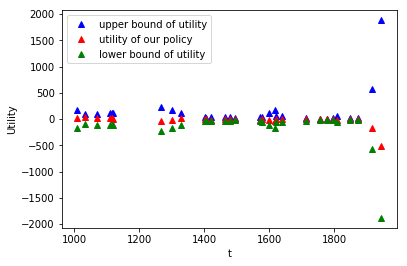

In [37]:

import numpy as np
import random
import hyper_param
import qlearning
import pickle

random.seed(1000)

def evaluate_reward(policy, test_data, random_index):
    policy_length = len(policy)
    reward = np.dot(policy, test_data[random_index:random_index+policy_length])
    reward -= (sum(policy)*test_data[random_index+policy_length-1])
    return reward

def upper_bound_of_maximum_gain(time_step, prices, horizon=100):
    #all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    all_prices_in_100_time_step = np.array(prices[time_step: time_step + horizon])
    closing_price = all_prices_in_100_time_step[-1]
    diff = all_prices_in_100_time_step - closing_price
    return np.sum(np.absolute(diff))  

def plotAll(t_array, upper_bound_array, reward_array):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(t_array, upper_bound_array, 'bx')
    plt.plot(t_array, reward_array, 'go')
    plt.show()
    
def plotAll2(t_array, upper_bound_array, reward_array):
    import pylab
    pylab.plot(t_array, upper_bound_array, 'b^', label='upper bound of utility')
    pylab.plot(t_array, reward_array, 'r^', label='utility of our policy')
    pylab.plot(t_array, -np.array(upper_bound_array), 'g^', label='lower bound of utility')
    pylab.legend(loc='upper left')
    pylab.xlabel('t')
    pylab.ylabel('Utility')
    pylab.show()
    
prices = hp.get_price_history().squeeze()
t_array = []
upper_bound_array = []
reward_array = []

for i in range(hp.get_evaluation_step()):
    random_time = random.randint(1000, 2000)
    policy_length = hyper_param.get_policy_length()
    #policy = generate_NN_1_step_policy(random_time, prices, policy_length)
    #qlearning_policy = qlearning.generate_Q_learning_policy(random_time, policy_length)
    
    t_array.append(random_time)
    upper_bound_array.append(upper_bound_of_maximum_gain(random_time, prices))
    #reward_array.append(evaluate.evaluate_reward(policy, prices, random_time))
    #reward_array.append(evaluate.evaluate_reward(qlearning_policy, prices, random_time))
    
plotAll2(t_array, upper_bound_array, reward_array)